### Imports

In [88]:
import pandas as pd
import torch
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from sklearn.preprocessing import MinMaxScaler
# set max num of rows and cols to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### Read Pre-processed Drug-Side-Effect List 

In [89]:
df_all_se = pd.read_csv('prep_data/drug_all_se_pubchem.csv')
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"['C0151828', 'C0030193', 'C0042109', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."


In [90]:
df_all_se.columns

Index(['STITCH ID STEREO', 'MEDRA TERM UMLS CONCEPT ID', 'se_count', 'cid',
       'mw', 'mf', 'polararea', 'complexity', 'xlogp', 'heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds', 'inchi', 'isosmiles',
       'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [91]:
drug_pub_prop_cols = [ 'mw', 'polararea', 'complexity','heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds']

In [92]:
df_all_se[drug_pub_prop_cols].isnull().sum()

mw            0
polararea     0
complexity    0
heavycnt      0
hbonddonor    0
hbondacc      0
rotbonds      0
dtype: int64

### Create Transformation Mapping for drug and side-effect

In [93]:
STITCH_TO_ID_DICT = {id: idx for idx, id in enumerate(df_all_se['STITCH ID STEREO'])}
ID_TO_STITCH_DICT = {v: k for k, v in STITCH_TO_ID_DICT.items()}

In [94]:
STITCHID_TO_PUBPPROP_DICT = {idx: _ for idx, (stid, _) in enumerate(zip(df_all_se['STITCH ID STEREO'], df_all_se[drug_pub_prop_cols].values))}


In [95]:
# Create a flattened list of unique meddra term concept id
column_list = df_all_se['MEDRA TERM UMLS CONCEPT ID'].tolist()
unique_values = list(set([item for sublist in column_list for item in eval(sublist)]))
unique_values.sort()
MEDRAID_TO_ID_DICT = {id: idx for idx, id in enumerate(unique_values)}
ID_TO_MEDRAID_DICT = {v: k for k, v in MEDRAID_TO_ID_DICT.items()}

In [96]:
# assert if df stitch id stereo is unique
assert len(df_all_se['STITCH ID STEREO'].unique()) == len(df_all_se['STITCH ID STEREO'])

### Create HeteroData

In [97]:
useMinMaxScaler = True

In [98]:
drug_node_features = torch.stack([torch.tensor(_, dtype=torch.float) for _ in df_all_se[drug_pub_prop_cols].values])
if useMinMaxScaler:
    scaler = MinMaxScaler()
    print("Before", drug_node_features.shape)
    drug_node_features = scaler.fit_transform(drug_node_features)
    print('After MinMax', drug_node_features.shape)
    drug_node_features = torch.tensor(drug_node_features, dtype=torch.float)
print("Final: UseMinMax", useMinMaxScaler, drug_node_features.shape)
# # Create a dictionary of node features
# drug_node_features = torch.tensor(np.zeros((len(df_all_se['STITCH ID STEREO']),881)))
# side_effect_node_features = torch.tensor(np.zeros((len(unique_values),881)))


# print('drug_nodes', drug_node_features.shape)
# print('side_effect_nodes', side_effect_node_features.shape)

Before torch.Size([1326, 7])
After MinMax (1326, 7)
Final: UseMinMax True torch.Size([1326, 7])


In [99]:
# create edge index for drug-side effect from multi-label column_list
edge_index = []
for idx, row in df_all_se.iterrows():
    for se in eval(row['MEDRA TERM UMLS CONCEPT ID']):
        edge_index.append([STITCH_TO_ID_DICT[row['STITCH ID STEREO']], MEDRAID_TO_ID_DICT[se]])
edge_index = torch.tensor(edge_index).T

# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', edge_index.shape)
print('edge_index', edge_index)

edge_index torch.Size([2, 129851])
edge_index tensor([[   0,    0,    0,  ..., 1325, 1325, 1325],
        [1091,  657,  889,  ...,  673,    2,  837]])


In [100]:
# # sanity check
# df_all_se.head(1)

In [101]:
# STITCH_TO_ID_DICT['CID000000119']

In [102]:
# MEDRAID_TO_ID_DICT['C0151828'], MEDRAID_TO_ID_DICT['C0030193'], MEDRAID_TO_ID_DICT['C0042109'], MEDRAID_TO_ID_DICT['C0002994']

In [103]:
# Create a heterograph with 2 types of nodes: drug and side effect
data = HeteroData()

# Add nodes
data['drug'].node_id = torch.arange(drug_node_features.shape[0])
data['side_effect'].node_id = torch.arange(len(unique_values))

# Add node features
data['drug'].x = drug_node_features

# Add edges
data['drug', 'side_effect'].edge_index = edge_index

print(data)

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)


### Hetero Data Viz

In [104]:
# # Full Graph View
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# from torch_geometric.data import HeteroData


# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()

In [105]:
# # Plot random number of edges and all associated nodes
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# import random
# from torch_geometric.data import HeteroData

# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Define the number of random edges you want to visualize
# num_random_edges = 10

# # Randomly select a subset of edges
# random_edge_indices = random.sample(range(data['drug', 'side_effect'].edge_index.shape[1]), num_random_edges)

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# # sample drug_nodes to have only nodes within random_edge_indices
# drug_nodes = np.unique(data['drug', 'side_effect'].edge_index[0, random_edge_indices].numpy())
# side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, random_edge_indices].numpy())


# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index[:, random_edge_indices]
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()


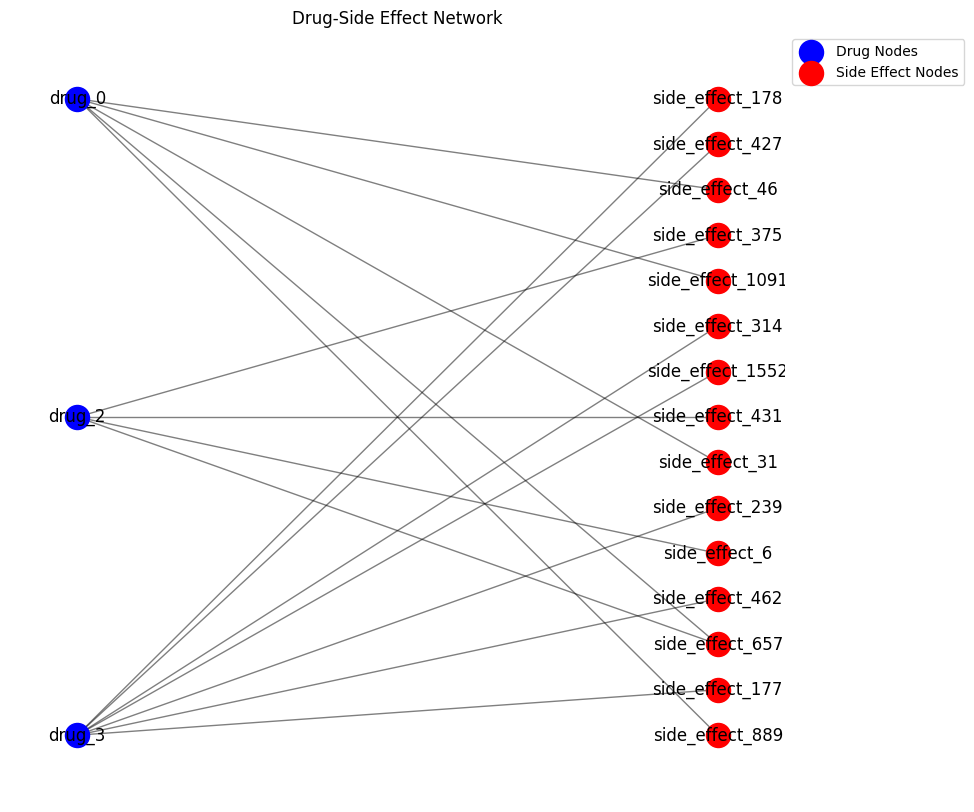

In [106]:
# plot for selected list of drug_id and all associated side effects
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random
from torch_geometric.data import HeteroData, Data

# Convert heterograph to NetworkX graph
graph = nx.Graph()

# list of drug_id to visualize all its associated side effects
drug_id_list = [0, 2, 3]

# associated possible unique side effects using edge_index when drug_id is in drug_id_list
side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list)].numpy())

# filter out edges that are between drug_id_list and side_effect_nodes
drug_edges = data['drug', 'side_effect'].edge_index[:, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list) & np.isin(data['drug', 'side_effect'].edge_index[1], side_effect_nodes)]

drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_id_list]
side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# Add nodes to the NetworkX graph
graph.add_nodes_from(drug_nodes_unique, node_type='drug')
graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# Add edges to the NetworkX graph
for i in range(drug_edges.shape[1]):
    source = drug_edges[0, i].item()
    target = drug_edges[1, i].item()
    source_id = f"drug_{source}"
    target_id = f"side_effect_{target}"
    graph.add_edge(source_id, target_id)

# Visualize the graph using NetworkX
# pos = nx.spring_layout(graph, seed=1)  # Compute node positions
pos = nx.bipartite_layout(graph, drug_nodes_unique, align='vertical', scale=5)  # Compute node positions
# Separate nodes by type for different visualization colors
drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# Draw nodes with different colors based on type
nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)

# Draw edges with different colors based on type

nx.draw_networkx_edges(graph, pos, edge_color='black', width=1.0, alpha=0.5)

# Draw edges
# nx.draw_networkx_edges(graph, pos)

# Draw node labels
node_labels = {n: str(n) for n in graph.nodes()}
nx.draw_networkx_labels(graph, pos, labels=node_labels)

# Display the graph
plt.axis('off')
# increase figure size
plt.gcf().set_size_inches(10, 10)
# position legend to the right of the graph
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Drug-Side Effect Network')
plt.show()


In [107]:
# graph.nodes()
# # link a map to most common drug_name and side_effect_name

### Convert Hetero to Homo Data

In [108]:
print(data)

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)


In [109]:
# Convert hererograph to homogeneous graph
data_homogeneous = data.to_homogeneous()

In [110]:
data_homogeneous

Data(edge_index=[2, 129851], node_id=[3387], x=[3387, 7], node_type=[3387], edge_type=[129851])

In [111]:
data_homogeneous.edge_index

tensor([[   0,    0,    0,  ..., 1325, 1325, 1325],
        [2417, 1983, 2215,  ..., 1999, 1328, 2163]])

In [112]:
data_homogeneous.node_type

tensor([0, 0, 0,  ..., 1, 1, 1])

### Homo Link Prediction task

In [113]:
data_homogeneous

Data(edge_index=[2, 129851], node_id=[3387], x=[3387, 7], node_type=[3387], edge_type=[129851])

In [114]:
import torch_geometric.transforms as T
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data_homogeneous = T.ToUndirected()(data_homogeneous)

In [115]:
data_homogeneous

Data(edge_index=[2, 259702], node_id=[3387], x=[3387, 7], node_type=[3387], edge_type=[259702])

### Define Edge level Train Split

In [116]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False
)

train_data, val_data, test_data = transform(data_homogeneous)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
Data(edge_index=[2, 145434], node_id=[3387], x=[3387, 7], node_type=[3387], edge_type=[145434], edge_label=[62328], edge_label_index=[2, 62328])

Validation data:
Data(edge_index=[2, 207762], node_id=[3387], x=[3387, 7], node_type=[3387], edge_type=[207762], edge_label=[77910], edge_label_index=[2, 77910])


### Define Mini-batch Loader

In [117]:
train_data.edge_label.shape, train_data.edge_label.sum()

(torch.Size([62328]), tensor(62328.))

In [118]:
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-1.12.1+cu117.html

In [119]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader.link_neighbor_loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data.edge_label_index
edge_label = train_data.edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[15, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=edge_label_index,
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
Data(edge_index=[2, 22381], node_id=[2729], x=[2729, 7], node_type=[2729], edge_type=[22381], edge_label=[384], edge_label_index=[2, 384], n_id=[2729], e_id=[22381], input_id=[128])


/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


### Creating a Homogenous Link-level GNN

In [120]:
sampled_data.num_nodes

2729

In [121]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from torch import Tensor


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.elu(self.conv1(x, edge_index)+self.lin1(x))
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x

In [122]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_drug = x[edge_label_index[0]]
        edge_feat_seff = x[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_drug * edge_feat_seff).sum(dim=-1)

In [123]:
data_homogeneous

Data(edge_index=[2, 259702], node_id=[3387], x=[3387, 7], node_type=[3387], edge_type=[259702])

In [124]:
# Homegenous Model for Edge Prediction
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Instantiate node embeddings:
        self.node_emb = torch.nn.Embedding(data_homogeneous.num_nodes, hidden_channels)
        # Instantiate GNNs:
        self.gnn = GNN(hidden_channels)
        # Instantiate classifier:
        self.classifier = Classifier() 

    def forward(self, x_data: Data) -> Tensor:
        x = self.node_emb(x_data.node_id)
        # Apply GNN:
        x = self.gnn(x, x_data.edge_index)
        # Apply classifier:
        x = self.classifier(x, x_data.edge_label_index)
        return x
        
model = Model(hidden_channels=256)
model

Model(
  (node_emb): Embedding(3387, 256)
  (gnn): GNN(
    (conv1): SAGEConv(256, 256, aggr=mean)
    (lin1): Linear(in_features=256, out_features=256, bias=True)
    (conv2): SAGEConv(256, 256, aggr=mean)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (classifier): Classifier()
)

### Train the homogenous model

In [36]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 21):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data.edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 487/487 [00:13<00:00, 35.79it/s]


Epoch: 001, Loss: 1.1102


100%|██████████| 487/487 [00:13<00:00, 35.91it/s]


Epoch: 002, Loss: 0.7269


100%|██████████| 487/487 [00:13<00:00, 36.99it/s]


Epoch: 003, Loss: 0.7050


100%|██████████| 487/487 [00:13<00:00, 35.72it/s]


Epoch: 004, Loss: 0.6939


100%|██████████| 487/487 [00:12<00:00, 38.61it/s]


Epoch: 005, Loss: 0.6869


100%|██████████| 487/487 [00:12<00:00, 38.87it/s]


Epoch: 006, Loss: 0.6816


100%|██████████| 487/487 [00:12<00:00, 39.27it/s]


Epoch: 007, Loss: 0.6787


100%|██████████| 487/487 [00:12<00:00, 39.39it/s]


Epoch: 008, Loss: 0.6756


100%|██████████| 487/487 [00:13<00:00, 36.31it/s]


Epoch: 009, Loss: 0.6735


100%|██████████| 487/487 [00:12<00:00, 37.81it/s]


Epoch: 010, Loss: 0.6707


100%|██████████| 487/487 [00:14<00:00, 32.77it/s]


Epoch: 011, Loss: 0.6710


100%|██████████| 487/487 [00:13<00:00, 35.21it/s]


Epoch: 012, Loss: 0.6698


100%|██████████| 487/487 [00:14<00:00, 33.15it/s]


Epoch: 013, Loss: 0.6698


100%|██████████| 487/487 [00:14<00:00, 33.65it/s]


Epoch: 014, Loss: 0.6692


100%|██████████| 487/487 [00:12<00:00, 38.42it/s]


Epoch: 015, Loss: 0.6653


100%|██████████| 487/487 [00:12<00:00, 39.07it/s]


Epoch: 016, Loss: 0.6647


100%|██████████| 487/487 [00:12<00:00, 38.98it/s]


Epoch: 017, Loss: 0.6648


100%|██████████| 487/487 [00:12<00:00, 39.23it/s]


Epoch: 018, Loss: 0.6637


100%|██████████| 487/487 [00:12<00:00, 39.27it/s]


Epoch: 019, Loss: 0.6636


100%|██████████| 487/487 [00:12<00:00, 39.30it/s]

Epoch: 020, Loss: 0.6625


In [38]:
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[15, 10],
    edge_label_index=val_data.edge_label_index,
    edge_label=val_data.edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
Data(edge_index=[2, 23532], node_id=[2661], x=[2661, 7], node_type=[2661], edge_type=[23532], edge_label=[384], edge_label_index=[2, 384], n_id=[2661], e_id=[23532], input_id=[384])


In [47]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data.edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

100%|██████████| 203/203 [00:04<00:00, 44.43it/s]


Validation AUC: 0.6695
Validation AP: 0.4357
Validation F1: 0.5922
Validation Accuracy: 0.6078


### Method Train and Val

In [135]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

@torch.no_grad()
def compute_metrics(model, val_loader, debug=False):
    model.eval()
    preds = []
    ground_truths = []
    total_examples = total_loss = 0
    for sampled_data in tqdm.tqdm(val_loader):
        with torch.no_grad():
            sampled_data.to(device)
            pred = model(sampled_data)
            loss = F.binary_cross_entropy_with_logits(pred, sampled_data.edge_label)
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
            # Applying sigmoid activation function to the predicted values
            output_probs = torch.sigmoid(pred)

            # Converting probabilities to binary class predictions
            output_classes = (output_probs > 0.5).int()
            preds.append(output_classes)
            ground_truths.append(sampled_data.edge_label)

    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

    auc = roc_auc_score(ground_truth, pred)
    ap = average_precision_score(ground_truth, pred)
    f1 = f1_score(ground_truth, pred)
    acc = (pred == ground_truth).mean()
    loss = total_loss / total_examples
    # compute precission, recall, f1, accuracy
    precission = average_precision_score(ground_truth, pred)
    recall = recall_score(ground_truth, pred)

    if debug:
        print()
        print(f"Validation AUC: {auc:.4f}")
        print(f"Validation AP: {ap:.4f}")
        print(f"Validation F1: {f1:.4f}")
        print(f"Validation Accuracy: {acc:.4f}")
        print(f"Validation Precission: {precission:.4f}")
        print(f"Validation Recall: {recall:.4f}")
    return loss, auc, ap, f1, acc

In [126]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = total_examples = 0
    for data in tqdm.tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        ground_truth = data.edge_label
        loss = F.binary_cross_entropy_with_logits(out, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * out.numel()
        total_examples += out.numel()
    return total_loss / total_examples

In [128]:
def main(model, train_loader, val_loader, test_loader, device, epochs, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )
    best_val_f1 = 0
    best_epoch = 0
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, device)
        _, train_auc, train_ap, train_f1, train_acc = compute_metrics(model, train_loader)
        # val_loss = test(model, val_loader, device)
        val_loss, val_auc, val_ap, val_f1, val_acc = compute_metrics(model, val_loader)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}\n,\
              Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}\n,\
              Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
       
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), f"{name}.pt")
        scheduler.step(val_f1)
    
    model.load_state_dict(torch.load(f"{name}.pt"))
    return model, best_epoch

In [129]:
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[15, 10],
    edge_label_index=test_data.edge_label_index,
    edge_label=test_data.edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

In [133]:
model = Model(hidden_channels=128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)

main(model, train_loader, val_loader, test_loader, device, epochs=20, name="homo_gcn")

Device: 'cuda'


  0%|          | 0/487 [00:00<?, ?it/s]

100%|██████████| 203/203 [00:06<00:00, 31.35it/s]


Epoch: 001, Loss: 0.8328, Val Loss: 0.7024
,              Train AUC: 0.5775, Train AP: 0.3740, Train F1: 0.4980, Train Acc: 0.5438
,              Val AUC: 0.5629, Val AP: 0.3654, Val F1: 0.4828, Val Acc: 0.5321


100%|██████████| 203/203 [00:06<00:00, 31.38it/s]


Epoch: 002, Loss: 0.6934, Val Loss: 0.6849
,              Train AUC: 0.6156, Train AP: 0.3976, Train F1: 0.5404, Train Acc: 0.5651
,              Val AUC: 0.6061, Val AP: 0.3914, Val F1: 0.5313, Val Acc: 0.5572


100%|██████████| 203/203 [00:06<00:00, 31.38it/s]


Epoch: 003, Loss: 0.6776, Val Loss: 0.6738
,              Train AUC: 0.6356, Train AP: 0.4114, Train F1: 0.5593, Train Acc: 0.5828
,              Val AUC: 0.6250, Val AP: 0.4039, Val F1: 0.5497, Val Acc: 0.5722


100%|██████████| 203/203 [00:06<00:00, 30.19it/s]


Epoch: 004, Loss: 0.6678, Val Loss: 0.6653
,              Train AUC: 0.6513, Train AP: 0.4219, Train F1: 0.5763, Train Acc: 0.5886
,              Val AUC: 0.6413, Val AP: 0.4147, Val F1: 0.5674, Val Acc: 0.5791


100%|██████████| 203/203 [00:06<00:00, 32.24it/s]


Epoch: 005, Loss: 0.6608, Val Loss: 0.6593
,              Train AUC: 0.6631, Train AP: 0.4304, Train F1: 0.5875, Train Acc: 0.5976
,              Val AUC: 0.6486, Val AP: 0.4196, Val F1: 0.5747, Val Acc: 0.5829


100%|██████████| 203/203 [00:06<00:00, 32.99it/s]


Epoch: 006, Loss: 0.6549, Val Loss: 0.6549
,              Train AUC: 0.6633, Train AP: 0.4308, Train F1: 0.5870, Train Acc: 0.6005
,              Val AUC: 0.6532, Val AP: 0.4234, Val F1: 0.5776, Val Acc: 0.5918


100%|██████████| 203/203 [00:06<00:00, 32.51it/s]


Epoch: 007, Loss: 0.6520, Val Loss: 0.6489
,              Train AUC: 0.6690, Train AP: 0.4351, Train F1: 0.5921, Train Acc: 0.6058
,              Val AUC: 0.6592, Val AP: 0.4276, Val F1: 0.5836, Val Acc: 0.5953


100%|██████████| 203/203 [00:06<00:00, 32.16it/s]


Epoch: 008, Loss: 0.6410, Val Loss: 0.6425
,              Train AUC: 0.6830, Train AP: 0.4455, Train F1: 0.6056, Train Acc: 0.6151
,              Val AUC: 0.6712, Val AP: 0.4360, Val F1: 0.5957, Val Acc: 0.6011


100%|██████████| 203/203 [00:06<00:00, 32.67it/s]


Epoch: 009, Loss: 0.6383, Val Loss: 0.6416
,              Train AUC: 0.6871, Train AP: 0.4487, Train F1: 0.6094, Train Acc: 0.6184
,              Val AUC: 0.6720, Val AP: 0.4365, Val F1: 0.5965, Val Acc: 0.6008


100%|██████████| 203/203 [00:07<00:00, 26.75it/s]


Epoch: 010, Loss: 0.6374, Val Loss: 0.6389
,              Train AUC: 0.6818, Train AP: 0.4452, Train F1: 0.6037, Train Acc: 0.6184
,              Val AUC: 0.6709, Val AP: 0.4366, Val F1: 0.5941, Val Acc: 0.6069


100%|██████████| 203/203 [00:07<00:00, 25.61it/s]


Epoch: 011, Loss: 0.6354, Val Loss: 0.6388
,              Train AUC: 0.6893, Train AP: 0.4505, Train F1: 0.6115, Train Acc: 0.6203
,              Val AUC: 0.6758, Val AP: 0.4395, Val F1: 0.5999, Val Acc: 0.6050


100%|██████████| 203/203 [00:07<00:00, 27.30it/s]


Epoch: 012, Loss: 0.6347, Val Loss: 0.6376
,              Train AUC: 0.6878, Train AP: 0.4493, Train F1: 0.6100, Train Acc: 0.6193
,              Val AUC: 0.6730, Val AP: 0.4375, Val F1: 0.5971, Val Acc: 0.6036


100%|██████████| 203/203 [00:07<00:00, 26.44it/s]


Epoch: 013, Loss: 0.6333, Val Loss: 0.6353
,              Train AUC: 0.6894, Train AP: 0.4510, Train F1: 0.6110, Train Acc: 0.6235
,              Val AUC: 0.6753, Val AP: 0.4395, Val F1: 0.5988, Val Acc: 0.6077


100%|██████████| 203/203 [00:07<00:00, 26.70it/s]


Epoch: 014, Loss: 0.6285, Val Loss: 0.6297
,              Train AUC: 0.6956, Train AP: 0.4560, Train F1: 0.6168, Train Acc: 0.6287
,              Val AUC: 0.6815, Val AP: 0.4443, Val F1: 0.6044, Val Acc: 0.6132


100%|██████████| 203/203 [00:07<00:00, 27.54it/s]


Epoch: 015, Loss: 0.6267, Val Loss: 0.6290
,              Train AUC: 0.6961, Train AP: 0.4562, Train F1: 0.6174, Train Acc: 0.6280
,              Val AUC: 0.6832, Val AP: 0.4454, Val F1: 0.6061, Val Acc: 0.6135


100%|██████████| 203/203 [00:07<00:00, 26.65it/s]


Epoch: 016, Loss: 0.6267, Val Loss: 0.6300
,              Train AUC: 0.6997, Train AP: 0.4588, Train F1: 0.6209, Train Acc: 0.6298
,              Val AUC: 0.6825, Val AP: 0.4446, Val F1: 0.6059, Val Acc: 0.6107


100%|██████████| 203/203 [00:05<00:00, 40.00it/s]


Epoch: 017, Loss: 0.6255, Val Loss: 0.6280
,              Train AUC: 0.6988, Train AP: 0.4582, Train F1: 0.6199, Train Acc: 0.6299
,              Val AUC: 0.6843, Val AP: 0.4462, Val F1: 0.6072, Val Acc: 0.6140


100%|██████████| 203/203 [00:05<00:00, 38.42it/s]


Epoch: 018, Loss: 0.6254, Val Loss: 0.6266
,              Train AUC: 0.7014, Train AP: 0.4606, Train F1: 0.6221, Train Acc: 0.6336
,              Val AUC: 0.6856, Val AP: 0.4475, Val F1: 0.6081, Val Acc: 0.6168


100%|██████████| 203/203 [00:07<00:00, 27.31it/s]


Epoch: 019, Loss: 0.6243, Val Loss: 0.6250
,              Train AUC: 0.7016, Train AP: 0.4605, Train F1: 0.6225, Train Acc: 0.6322
,              Val AUC: 0.6872, Val AP: 0.4485, Val F1: 0.6100, Val Acc: 0.6162


100%|██████████| 203/203 [00:08<00:00, 24.65it/s]

Epoch: 020, Loss: 0.6215, Val Loss: 0.6228
,              Train AUC: 0.7054, Train AP: 0.4638, Train F1: 0.6258, Train Acc: 0.6367
,              Val AUC: 0.6889, Val AP: 0.4499, Val F1: 0.6114, Val Acc: 0.6183


(Model(
   (node_emb): Embedding(3387, 128)
   (gnn): GNN(
     (conv1): SAGEConv(128, 128, aggr=mean)
     (lin1): Linear(in_features=128, out_features=128, bias=True)
     (conv2): SAGEConv(128, 128, aggr=mean)
     (lin2): Linear(in_features=128, out_features=128, bias=True)
   )
   (classifier): Classifier()
 ),
 20)

In [136]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 203/203 [00:05<00:00, 36.38it/s]


Validation AUC: 0.6920
Validation AP: 0.4527
Validation F1: 0.6139
Validation Accuracy: 0.6233
Validation Precission: 0.4527
Validation Recall: 0.8983


(0.6225246314411215,
 0.6920485175202156,
 0.4527196505313831,
 0.6138645124791139,
 0.6232961108971891)

In [ ]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 203/203 [00:05<00:00, 37.77it/s]


Validation AUC: 0.6416
Validation AP: 0.4140
Validation F1: 0.5707
Validation Accuracy: 0.5689


(0.7058300123060489,
 0.6415864458991145,
 0.41396541852310625,
 0.5707128798916239,
 0.5688615068668977)

In [82]:
compute_metrics(model, train_loader, debug=True)

100%|██████████| 487/487 [00:12<00:00, 39.61it/s]



Validation AUC: 0.6819
Validation AP: 0.4426
Validation F1: 0.6074
Validation Accuracy: 0.5988


(0.6873242770993592,
 0.6818644910794507,
 0.442623111038149,
 0.6074046940003663,
 0.5987731570615668)